<a href="https://colab.research.google.com/github/yeb2Binfang/DS_GY_3001_CV/blob/main/HW/HW4/homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 4: Neural Networks

**Due date:** May 2, 2021

The goal of the assignment is to train a simple neural network on MNIST data.

*Note:* This notebook requires Python 3.

**Instructions:**

* Read and understand the provided code, which is a basic implementation of a neural network as a modular architecture.
* Download the [MNIST data](http://deeplearning.net/data/mnist/mnist.pkl.gz) (~15Mo). It consists of 28x28 images (loaded as a 784 vector) and the associated labels for training, validation and test sets. For this homework, you will only use the training and validation sets. 
* Write a simple loop to train 50 iterations of the implemented MLP (multi-layer perceptron) with a learning rate 0.001 and batches of size 16. Plot the training and validation losses throughout the training process (you don't have to test your network at every iteration, you can do it for example every 10 iterations).
* Evaluate the accuracy of your trained model on the training and validation data. Check the predictions on random validation images.
* Try changing learning rate and batch size and see if you can improve your results.
* How many parameters does the network have? Implement and experiment with some variations of the architecture, for example:
    * Implement and use the cross-entropy loss instead of L2 loss.
    * Add a parameter to vary the size of the intermediate layer.
    * Use a MLP with 3 layers and parameters for the sizes of the two intermediate layers.


## MLP implementation

### Import packages

In [10]:
import numpy as np 
import math
import matplotlib.pyplot as plt 
%matplotlib inline 
plt.rcParams['image.cmap'] = 'gray' 
import gzip
import pickle

### Module

In [11]:
class Module(object):
    def __init__(self):
        self.gradInput=None 
        self.output=None
        
    def forward(self, *input):
        """Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
    def backward(self, *input):
        """Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError

### Linear

In [12]:
class Linear(Module):
    """
    The input is supposed to have two dimensions (batchSize,in_feature)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = math.sqrt(1. / (out_features* in_features))*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)
        self.gradWeight=None
        self.gradBias=None
        
    def forward(self, x):
        self.output= np.dot(x,self.weight.transpose())+np.repeat(self.bias.reshape([1,-1]),x.shape[0], axis=0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=np.dot(gradOutput,self.weight)
        self.gradWeight=np.dot(gradOutput.transpose(),x)
        self.gradBias=np.sum(gradOutput, axis=0)
        return self.gradInput
    
    def gradientStep(self,lr):
        self.weight=self.weight-lr*self.gradWeight
        self.bias=self.bias-lr*self.gradBias

### ReLU

In [13]:
class ReLU(Module):
    
    def __init__(self, bias=True):
        super(ReLU, self).__init__()
        
    def forward(self, x):
        self.output=x.clip(0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=(x>0)*gradOutput
        return self.gradInput

### Least Square Error


In [14]:
class LeastSquareCriterion(Module):
    """
    This implementation of the least square loss assumes that the data comes as a 2 dimensional array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(LeastSquareCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x,labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = np.sum((target-x)**2,axis=0)
        return np.sum(self.output)
    
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i,labels[i]]=x[i,labels[i]]-1
        return self.gradInput

### MLP 

In [15]:
class MLP(Module):

    def __init__(self, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = Linear(784, 64)
        self.relu1 = ReLU()
        self.fc2 = Linear(64, 10)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self,lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

## Load and visualize the dataset

In [16]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [17]:
with open('MyDrive/MyDrive/DS/mnist.pkl', 'rb') as f:
  ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding='latin-1')

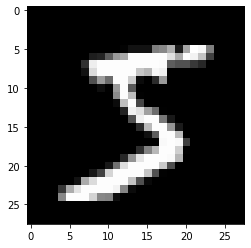

In [18]:
plt.imshow(x_train[0].reshape((28,28)))

In [19]:
print(y_train[0])

5


## Train MLP
Write a simple loop to train 50 iterations of the implemented MLP (multi-layer perceptron) with a learning rate 0.001 and batches of size 16. Plot the training and validation losses throughout the training process (you don't have to test your network at every iteration, you can do it for example every 10 iterations).

In [23]:
pip install tqdm

In [24]:
from tqdm import tqdm

In [37]:
Net = MLP()
Error = LeastSquareCriterion()

n_iter = 50
lr = 0.001
batch_size = 16

train_errors = []
val_errors = []
for epoch in range(n_iter):
  #print(str(epoch) + " epoch")
  if (epoch%10 == 0):
    #write your code here
    val_forward = Net.forward(x_valid)
    val_loss = Error.forward(val_forward, y_valid)
    val_errors.append(val_loss)

    train_forward = Net.forward(x_train)
    train_loss = Error.forward(train_forward, y_train)
    train_errors.append(train_loss)

  for i in tqdm(range(0,len(x_train),batch_size)):
    #write your code here
    if i==0:
      continue
    index = np.arange(i-batch_size,i)
    x_forward = Net.forward(x_train[index])
    grad_loss = Error.backward(x_forward, y_train[index])
    Net.backward(x_train[index], grad_loss)
    Net.gradientStep(lr)


100%|██████████| 3125/3125 [00:04<00:00, 729.31it/s]


In [38]:
print(train_errors)

[49849.86147166136, 5907.882384508182, 4891.491765174849, 4447.502279344168, 4214.750902104069]


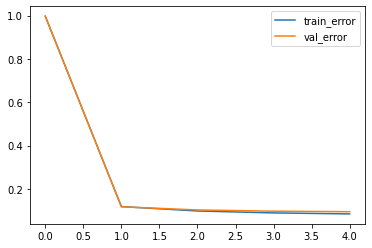

In [52]:
train_loss = np.array(train_errors)/len(x_train)
val_loss = np.array(val_errors)/len(x_valid)
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train_error","val_error"])

## Evaluate the model accuracy
Evaluate the accuracy of your trained model on the training and validation data. Check the predictions on random validation images.

In [44]:
val_predictions = Net.forward(x_valid)
train_predictions = Net.forward(x_train)

print("Average train error:")
print(Error.forward(train_predictions,y_train)/len(x_train))

print("Average validation error:")
print(Error.forward(val_predictions,y_valid)/len(x_valid))

Average train error:
0.08093237785963325
Average validation error:
0.09322046514861149


true label: 1
predict label: 1


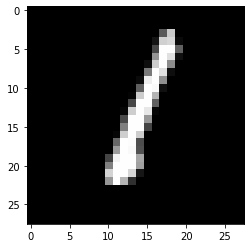

In [48]:
m = np.random.randint(len(x_valid))
plt.imshow(x_valid[m,:].reshape(28,28))
print("true label: "+str(y_valid[m]))
prediction = Net.forward(x_valid[m,:].reshape([1,-1]))
print("predict label: "+ str(prediction.argmax()))

## Try to imporve
Try changing learning rate and batch size and see if you can improve your results.
Here, I changed learning rate to 0.0001 and changed the batch-size to 8. 

In [56]:
Net1 = MLP()
Error1 = LeastSquareCriterion()

n_iter = 50
lr1 = 0.0001
batch_size1 = 8

train_errors1 = []
val_errors1 = []
for epoch in range(n_iter):
  #print(str(epoch) + " epoch")
  if (epoch%10 == 0):
    #write your code here
    val_forward = Net1.forward(x_valid)
    val_loss = Error1.forward(val_forward, y_valid)
    val_errors1.append(val_loss)

    train_forward = Net1.forward(x_train)
    train_loss = Error1.forward(train_forward, y_train)
    train_errors1.append(train_loss)

  for i in tqdm(range(0,len(x_train),batch_size1)):
    #write your code here
    if i==0:
      continue
    index = np.arange(i-batch_size1,i)
    x_forward = Net1.forward(x_train[index])
    grad_loss = Error1.backward(x_forward, y_train[index])
    Net1.backward(x_train[index], grad_loss)
    Net1.gradientStep(lr1)

100%|██████████| 6250/6250 [00:07<00:00, 867.99it/s]


The result is not as good as above. So, I think when the learning rate=0.001 and the batch-szie = 16 is good enough

In [58]:
val_predictions1 = Net1.forward(x_valid)
train_predictions1 = Net1.forward(x_train)

print("Average train error:")
print(Error1.forward(train_predictions1,y_train)/len(x_train))

print("Average validation error:")
print(Error1.forward(val_predictions1,y_valid)/len(x_valid))

Average train error:
0.13734056088156757
Average validation error:
0.13169956061025528


## Try different things
How many parameters does the network have?

From the above network architecture (784->64->10), we can calculate the number of parameters: 784 x 64 + 64 + 64 x 10 + 10



### Implement and use the cross-entropy loss instead of L2 loss.

In [ ]:
class CrossEntropyCriterion(Module):
    """
    This implementation of the least square loss assumes that the data comes as a 2 dimensional array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(LeastSquareCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x,labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = np.sum((target-x)**2,axis=0)
        return np.sum(self.output)
    
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i,labels[i]]=x[i,labels[i]]-1
        return self.gradInput

### Add a parameter to vary the size of the intermediate layer.

### 3 layers MLP
Use a MLP with 3 layers and parameters for the sizes of the two intermediate layers.